# Реализация функции определения сложности слова (Гареева)

Для определения сложности слова напишем функцию, которая будет принимать на вход строку-слово и возвращать значение каждого параметра сложности от 0 до 1, где 0 - очень простое слово, 1 - очень сложное, и их среднюю сложность.

Для этого напишем отдельно функции определения сложности каждого параметра, которые будут возвращать значение от 0 до 1.

In [1]:
import os
import shutil
import io
import zipfile
import requests
import string
import pandas as pd
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

### Приведение слова к нужному формату

Многие библиотеки, работающие со словами, и датасеты со словами, используют только определенные форматы: строчные буквы, нет лишних пробелов, нормальная форма. Нужно уметь преобразовывать любое слово к такому формату - для этого напишем функцию преобразования, которая к тому же определяет часть речи слова.

Для приведения слова к нормальной форме будем использовать библиотеку **pymorphy2** (https://pymorphy2.readthedocs.io/en/stable/index.html), которая может привести к нормальной форме даже несуществующее слово.

In [2]:
# %pip install pymorphy2

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def transform_word(word: str) -> tuple:
    word = word.lower().strip()
    morph_parse = morph.parse(word)[0]
    return word, morph_parse.normal_form, morph_parse.tag.POS 

Протестируем

In [4]:
print(transform_word(word='танцующий'))
print(transform_word(word='  кОшКоЙ '))

('танцующий', 'танцующий', 'ADJF')
('кошкой', 'кошка', 'NOUN')


### Датасеты

Для работы с частотностью слов, скачаем открытый датасет (52138 слов) с большим количеством лемм (нормальных форм слова) с их частотностью (**Freq(ipm)**), приведем леммы к строчным буквам и оставим только нужные нам параметры (**Lemma, Freq(ipm)**), добавив параметр длины слова (**length**).

О. Н. Ляшевская, С. А. Шаров НОВЫЙ ЧАСТОТНЫЙ СЛОВАРЬ РУССКОЙ ЛЕКСИКИ (http://dict.ruslang.ru/freq.php)

In [5]:
dirname = 'datasets/freq'
r = requests.get('http://dict.ruslang.ru/Freq2011.zip')
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall(dirname)

freq_df = pd.read_csv(os.path.join(dirname, 'freqrnc2011.csv'), sep='\t')[['Lemma', 'Freq(ipm)']]
freq_df['Lemma'] = freq_df['Lemma'].str.lower()
freq_df['length'] = freq_df['Lemma'].str.len()

freq_df.info()
freq_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52138 entries, 0 to 52137
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lemma      52138 non-null  object 
 1   Freq(ipm)  52138 non-null  float64
 2   length     52138 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


,Lemma,Freq(ipm),length
375,азимут,1.6,6
45410,терние,1.2,6
44291,стряпня,1.0,7
40870,сдержаться,6.4,10
28651,отходчивый,0.6,10


Для работы с морфемами слов, скачаем открытый датасет (103526 слов) с большим количеством лемм (нормальных форм слова) с их морфологическим разбором, приведем леммы к строчным буквам и оставим только их с нужным нам разбором слова по составу (**Lemma, analysis**), добавив количество морфем (**count_morph**). 

А.Н. Тихонов. Словообразовательный словарь русского языка в двух томах. (http://speakrus.ru/dict2/index.htm)

In [6]:
dirname = 'datasets/tikhonov'
fullname = os.path.join(dirname, 'tikhonov.txt')

shutil.rmtree(dirname, ignore_errors=True)

r = requests.get('http://www.speakrus.ru/dict2/tikhonov.zip')
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall(dirname)

with open(os.path.join(dirname, os.listdir(dirname)[0]), 'rb') as f:
    text = f.read().decode('cp1251')
    with open(fullname, 'wb') as ru:
        ru.write(text.encode('utf-8'))
        
morph_df = pd.read_csv(fullname, sep='|', names=['Lemma', 'analysis'])
morph_df['Lemma'] = morph_df['Lemma'].str.replace('\d+', '').str.split().str[0].str.lower()
morph_df['analysis'] = morph_df['analysis'].str.replace('\d+', '').str.split(pat=',', n=1).str[0].str.split().str[0]
morph_df['count_morph'] = morph_df['analysis'].str.count(pat='/') + 1

morph_df.info()
morph_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103526 entries, 0 to 103525
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Lemma        103526 non-null  object
 1   analysis     103526 non-null  object
 2   count_morph  103526 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


,Lemma,analysis,count_morph
78498,ревизовать,ревиз/ова'/ть,3
24399,замоноличивать,за/моно/ли'ч/ива/ть,5
35501,культкомиссия,культ/коми'сси/я,3
71533,прогон,про/го'н/,3
56871,педант,педа'нт/,2


### Фонетическая транскрипция

Напишем функцию определения сложности параметра соотношения фонетической и графической сложности. (Чем сильнее несоотношение, тем больше параметр сложности.) 

Для этого напишем функцию создания транскрипции, пренебрегая обозначениями мягкости (они не влияют на неочевидность написания) и ударениями (будем считать, что любая гласная безударная), используя известные правила русского языка из открытых источников. (https://tutrus.com/fonetika/foneticheskiy-razbor-nachalnaya-shkola) Если буква имеет нетривиальную фонетическую запись или беззвучна, будем добавлять ей очко сложности. 

In [7]:
vowels = set('аяоёуюыиэе')
consonants = set('бвгджзйклмнпрстфхцчшщ')
marks = set('ъь')

deaf_consonants = set('пфктшсхцчщ')
voices_consonants = set('лмнрйбвгджз')

ioted_vowels = { 
    'я' : {'one': 'а', 'two': 'йа'},
    'ё' : {'one': 'о', 'two': 'йо'},
    'ю' : {'one': 'у', 'two': 'йу'},
    'е' : {'one': 'э', 'two': 'йэ'},
}

stress_vowels = {
    'о': {'stress': 'о', 'not_stress': 'a'},
    'е': {'stress': 'э', 'not_stress': 'и'},
    'я': {'stress': 'а', 'not_stress': 'и'},
}

deaf_pairs = {
    'б': 'п',
    'в': 'ф',
    'г': 'к',
    'д': 'т',
    'ж': 'ш',
    'з': 'с'
}

simple_groups = { #abc -> ac
    'с' : {'т': set('нл')}, # стн, стл 
    'н' : {'д': set('шц'), 'т': 'г'}, # ндш, ндц, нтг
    'з' : {'д': set('нц')}, # здн, здц
    'р' : {'д': set('цч')} # рдц, рдч 
}

sh_groups = { # ab -> шb
    'ч' : set('нт') # чн, чт
}

sch_groups = { # ab -> щ
    'с' : 'ч', # сч
    'з' : 'ч', # зч
    'ж' : 'ч', # жч
}

def get_transcription(word: str) -> tuple:
    difficulty = [0] * len(word)
    transcription = ['!'] * len(word)
    for i in range(len(word)):
        c = word[i]
        before_c = word[i - 1] if i > 0 else None
        after_c = word[i + 1] if i < len(word) - 1 else None
        after_after_c = word[i + 2] if i < len(word) - 2 else None
        if c in vowels:
            transcription[i] = c
            difficulty[i] = 0
            if c in ioted_vowels:
                if i == 0 or before_c in vowels or before_c in marks:
                    transcription[i] = ioted_vowels[c]['two']
                    difficulty[i] = 2
                else:
                    transcription[i] = ioted_vowels[c]['one']
                    difficulty[i] = 1
            elif c == 'и':
                if before_c == 'ь':
                    transcription[i] = 'йи'
                    difficulty[i] = 2
                elif before_c in set('жшц'):
                    transcription[i] = 'ы'
                    difficulty[i] = 1
                else:
                    transcription[i] = 'и'
                    difficulty[i] = 0
            elif c in stress_vowels:
                transcription[i] = stress_vowels[c]['not_stress']
                difficulty[i] = 1
        elif c in consonants:
            transcription[i] = c
            difficulty[i] = 0
            if c in deaf_pairs:
                if i == len(word) - 1 or after_c in deaf_consonants:
                    transcription[i] = deaf_pairs[c]
                    difficulty[i] = 1
            if before_c and after_c and\
                before_c in simple_groups and\
                c in simple_groups[before_c] and\
                after_c in simple_groups[before_c][c]:
                transcription[i] = ''
                difficulty[i] = 1
            if before_c in sh_groups and c in sh_groups[before_c]:
                transcription[i - 1] = 'ш'
                difficulty[i - 1] = 1
            if before_c in sch_groups and c in sch_groups[before_c]:
                transcription[i - 1] = 'щ'
                difficulty[i - 1] = 1
                transcription[i] = ''
                difficulty[i] = 1
            if before_c == 'л' and c == 'н' and after_c == 'ц':
                transcription[i - 1] = ''
                difficulty[i - 1] = 1
            if before_c == 'в' and c == 'с' and after_c == 'т' and after_after_c == 'в':
                transcription[i - 1] = ''
                difficulty[i - 1] = 1
            if i == 0 and c == 'с' and after_c in voices_consonants:
                transcription[i] = 'з'
                difficulty[i] = 1
            if c == 'г' and after_c in deaf_consonants:
                transcription[i] = 'x'
                difficulty[i] = 1
            if before_c == c:
                transcription[i] = ''
                difficulty[i] = 1
        else:
            transcription[i] = ''
            difficulty[i] = 1
    if word.endswith(('ого', 'его')):
        transcription[-2] = 'в'
        difficulty[-2] = 1
    if word.endswith('тся'):
        transcription[-3] = 'ц'
        difficulty[-3] = 1
        transcription[-2] = ''
        difficulty[-2] = 1
    if word.endswith('ться'):
        transcription[-4] = 'ц'
        difficulty[-4] = 1
        transcription[-3] = ''
        difficulty[-3] = 1
        transcription[-2] = ''
        difficulty[-2] = 1
    return sum(difficulty), difficulty, transcription

Протестируем

In [8]:
print(get_transcription(word='поёт'), '[пай’от]')
print(get_transcription(word='чьи'), '[ч’й’и]')
print(get_transcription(word='лисьи'), '[лис’й’и]')
print(get_transcription(word='гриб'), '[гр’ип]')
print(get_transcription(word='солнце'), '[сОнцэ]')
print(get_transcription(word='ванна'), '[ван:а]')
print(get_transcription(word='конечно'), '[кан‘эшна]')
print(get_transcription(word='счастливый'), '[щ‘асливый‘]')
print(get_transcription(word='белого'), '[б’Элава]')
print(get_transcription(word='бриться'), '[бр’иц:а]')

(3, [0, 1, 2, 0], ['п', 'a', 'йо', 'т']) [пай’от]
(3, [0, 1, 2], ['ч', '', 'йи']) [ч’й’и]
(3, [0, 0, 0, 1, 2], ['л', 'и', 'с', '', 'йи']) [лис’й’и]
(1, [0, 0, 0, 1], ['г', 'р', 'и', 'п']) [гр’ип]
(3, [0, 1, 1, 0, 0, 1], ['с', 'a', '', 'н', 'ц', 'э']) [сОнцэ]
(1, [0, 0, 0, 1, 0], ['в', 'а', 'н', '', 'а']) [ван:а]
(4, [0, 1, 0, 1, 1, 0, 1], ['к', 'a', 'н', 'э', 'ш', 'н', 'a']) [кан‘эшна]
(3, [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], ['щ', '', 'а', 'с', '', 'л', 'и', 'в', 'ы', 'й']) [щ‘асливый‘]
(4, [0, 1, 0, 1, 1, 1], ['б', 'э', 'л', 'a', 'в', 'a']) [б’Элава]
(4, [0, 0, 0, 1, 1, 1, 1], ['б', 'р', 'и', 'ц', '', '', 'а']) [бр’иц:а]


Функция получает транскрипции, которые могут расходиться с корректным результатом (например, из-за того, что мы не учитываем ударение), но достаточно хорошо определяет сложность.

Нарисуем столбчатую диаграмму сложности транскрипции слова на основе датасета с частотами, чтобы посмотреть распределение и сделать корректную функцию определения сложности параметра транскрипции слова.

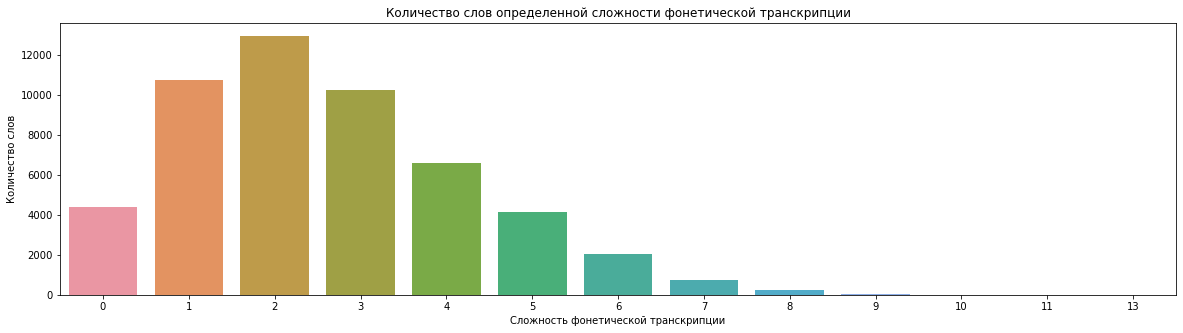

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.countplot(x=freq_df['Lemma'].apply(lambda word: get_transcription(word)[0]))

ax.set_title('Количество слов определенной сложности фонетической транскрипции')
ax.set_ylabel('Количество слов')
ax.set_xlabel('Сложность фонетической транскрипции')

plt.show()

Заметим, что мы можем выделить примерно нормальное распределение со средним в значении 2, а слов длиннее 5 очень мало.

Нормализуем длину от 0 до 1 по методу минимакс так, чтобы значение 0.5 соотносилось со средним значением. Для этого за минимум возьмем значение 0, за максимум 5.

На вход будем принимать любую форму слова (не будем приводить к лемме), так как окончания могут иметь сложное произношение.

In [10]:
MIN_PHONEME = 0
MAX_PHONEME = 5

def word_phoneme_param(word: str) -> float:
    difficulty, _, _= get_transcription(word)
    normalize_phoneme = (difficulty - MIN_PHONEME) / (MAX_PHONEME - MIN_PHONEME)
    return max(0, min(normalize_phoneme, 1))

Протестируем

In [11]:
print(word_phoneme_param(word='маги'))
print(word_phoneme_param(word='я'))
print(word_phoneme_param(word='поёт'))
print(word_phoneme_param(word='абсолютность'))

0
0.4
0.6
1.0


### Длина слова

Напишем функцию определения сложности параметра длины слова. (Чем длиннее слово, тем больше должен быть параметр сложности слова по длине.) Для этого сделаем преданализ данных из вышеупомянутого датасета.

Нарисуем столбчатую диаграмму длин слова, чтобы посмотреть распределение и сделать корректную функцию определения сложности параметра длины слова.

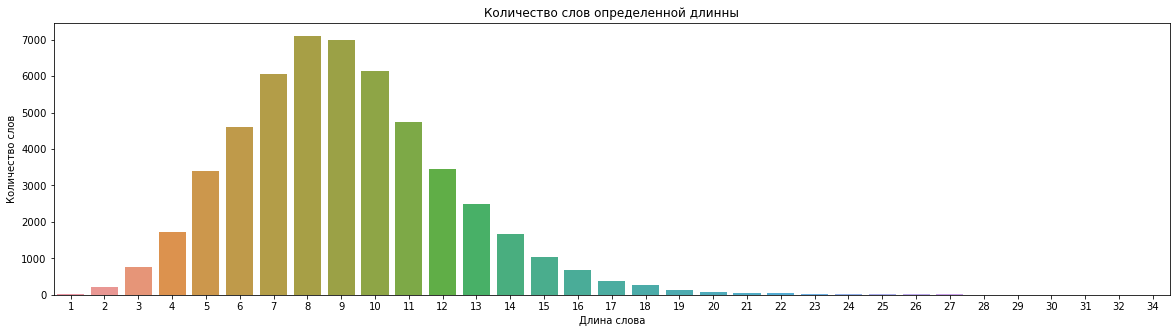

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.countplot(x=freq_df['length'])

ax.set_title('Количество слов определенной длинны')
ax.set_ylabel('Количество слов')
ax.set_xlabel('Длина слова')

plt.show()

Заметим, что мы можем выделить примерно нормальное распределение со средним в значении 8-9, а слов длиннее 14 очень мало.

Нормализуем длину от 0 до 1 по методу минимакс так, чтобы значение 0.5 соотносилось со средним значением. Для этого за минимум возьмем значение 4, за максимум 14.

На вход будем принимать любую форму слова (не будем приводить к лемме), так как слова удлиняемые сложными окончаниями, можно считать сложнее.

In [13]:
MIN_LENGTH = 4
MAX_LENGTH = 14

def word_length_param(word: str) -> float:
    normalize_length = (len(word) - MIN_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
    return max(0, min(normalize_length, 1))

Протестируем

In [14]:
print(word_length_param(word='a'))
print(word_length_param(word='aaaaa'))
print(word_length_param(word='aaaaaaaaa'))
print(word_length_param(word='aaaaaaaaaaaaaa'))
print(word_length_param(word='aaaaaaaaaaaaaaaaaaaa'))

0
0.1
0.5
1.0
1


### Частотность слова

Напишем функцию определения сложности параметра частотности слова. (Чем больше частота использования слово, тем меньше должен быть параметр сложности слова по частотности.) Для этого сделаем преданализ данных из вышеупомянутого датасета.

Найдем минимальную и максимальную частотность слов.

In [15]:
print('Минимальная частотность:', freq_df['Freq(ipm)'].min())
print('Максимальная частотность:', freq_df['Freq(ipm)'].max())

Минимальная частотность: 0.4
Максимальная частотность: 35801.8


Построим графики со словами в различных промежутках частотности, выводя примеры слов с минимальной и максимальной частотностью, чтобы определить лучшие границы для нормализации длины от 0 до 1 по методу минимакс.

In [16]:
def show_freq_distplot(FROM, TO):
    condition = ((FROM <= freq_df['Freq(ipm)']) & (freq_df['Freq(ipm)'] <= TO))

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.distplot(x=freq_df[condition]['Freq(ipm)'])

    ax.set_title('Распределение частоты слов от ' + str(FROM) + ' до ' + str(TO))
    ax.set_ylabel('Плотность')
    ax.set_xlabel('Часота слова')

    plt.show()
    
    sorted_freq_df = freq_df[condition].sort_values(by=['Freq(ipm)', 'Lemma'])
    print('Слова с минимальной частотностью:\n', sorted_freq_df.head(5)['Lemma'].values)
    print('Слова с максимальной частотностью:\n', sorted_freq_df.tail(5)['Lemma'].values)

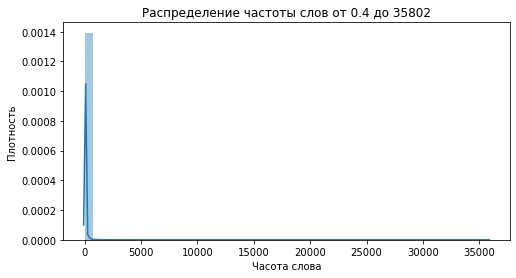

Слова с минимальной частотностью:
 ['абонементный' 'абсолютность' 'абсорбент' 'абстрагировать' 'абсцесс']
Слова с максимальной частотностью:
 ['я' 'на' 'не' 'в' 'и']


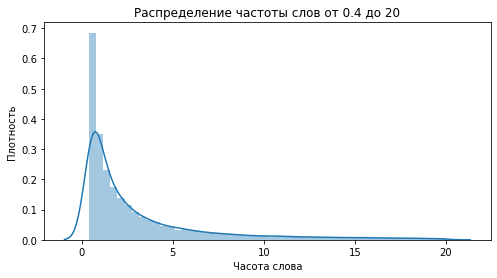

Слова с минимальной частотностью:
 ['абонементный' 'абсолютность' 'абсорбент' 'абстрагировать' 'абсцесс']
Слова с максимальной частотностью:
 ['тем' 'толкнуть' 'турция' 'убирать' 'чубайс']


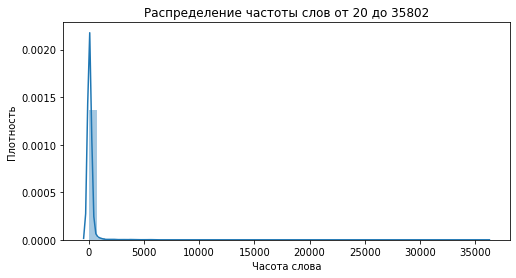

Слова с минимальной частотностью:
 ['автоматически' 'аэродром' 'буфет' 'винтовка' 'жажда']
Слова с максимальной частотностью:
 ['я' 'на' 'не' 'в' 'и']


In [17]:
show_freq_distplot(FROM=0.4, TO=35802)
show_freq_distplot(FROM=0.4, TO=20)
show_freq_distplot(FROM=20, TO=35802)

Нормального распределения не вышло, но достаточно понятные результаты выходят в границах от 0.4 до 20.

На вход будем принимать нормальную форму слова (будем приводить к лемме), так как слова берутся из словаря с леммами. Если слова нет в словаре, то не будем учитывать данный параметр.

In [18]:
MIN_FREQ = 0.4
MAX_FREQ = 20

def word_freq_param(lemma: str) -> Optional[float]:
    found_lemma = freq_df[freq_df['Lemma'] == lemma]
    if found_lemma.empty:
        return None
    freq = found_lemma['Freq(ipm)'].head(1).item()
    normalize_freq = (freq - MIN_FREQ) / (MAX_FREQ - MIN_FREQ)
    return 1 - max(0, min(normalize_freq, 1))

Протестируем

In [19]:
print(word_freq_param(lemma='None'))
print(word_freq_param(lemma='я'))
print(word_freq_param(lemma='убирать'))
print(word_freq_param(lemma='попугай'))
print(word_freq_param(lemma='кулич'))
print(word_freq_param(lemma='касситерит'))

None
0
0.0
0.5102040816326532
0.9489795918367347
1


### Часть речи слова

Будем определять семантическую сложность через частеречную принадлежность. Для этого будем использовать библиотеку pymorphy2 (https://pymorphy2.readthedocs.io/en/stable/index.html), которая может попытаться определить частеречную принадлежность даже несуществующего слова.(https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html)

Разобьем слова на группы по семантической сложности (чем сложнее смысл, тем больше должен быть параметр сложности слова по части речи):
- мало несущие в себе смысл (0): 
    - числительное (NUMR)
    - наречие (ADVB)
    - местоимение-существительное (NPRO)
    - предикатив (PRED)
    - предлог (PREP)
    - союз (CONJ)
    - частица (PRCL)
    - междометие (INTJ)
- изначально созданы для обозначения реальных и наглядных вещей (0.5): 
    - имя существительное (NOUN)
    - имя прилагательное (полное - ADJF, краткое - ADJS)
    - компаратив (COMP)
    - глагол (личная форма - VERB, инфинитив - INFN)
- имеющие сложные смысловые значения (1):
    - причастие (полное - PRTF, краткое - PRTS)
    - деепричастие (GRND)
    
На вход будем принимать уже часть речи.

In [20]:
simple_POS = {'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}
medium_POS = {'NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN'}
difficult_POS = {'PRTF', 'PRTS', 'GRND'}

def word_POS_param(POS: str) -> Optional[float]:
    if POS in simple_POS:
        return 0
    if POS in medium_POS:
        return 0.5
    if POS in difficult_POS:
        return 1
    return None

Протестируем

In [21]:
print(word_POS_param(POS=morph.parse('None')[0].tag.POS))
print(word_POS_param(POS=morph.parse('я')[0].tag.POS))
print(word_POS_param(POS=morph.parse('иду')[0].tag.POS))
print(word_POS_param(POS=morph.parse('пританцовывая')[0].tag.POS))

None
0
0.5
1


### Морфемный разбор слова

Напишем функцию определения сложности параметра морфем слова. (Чем больше в слове морфем, тем больше должен быть параметр сложности слова по морфемам.) Для этого сделаем преданализ данных из вышеупомянутого датасета.

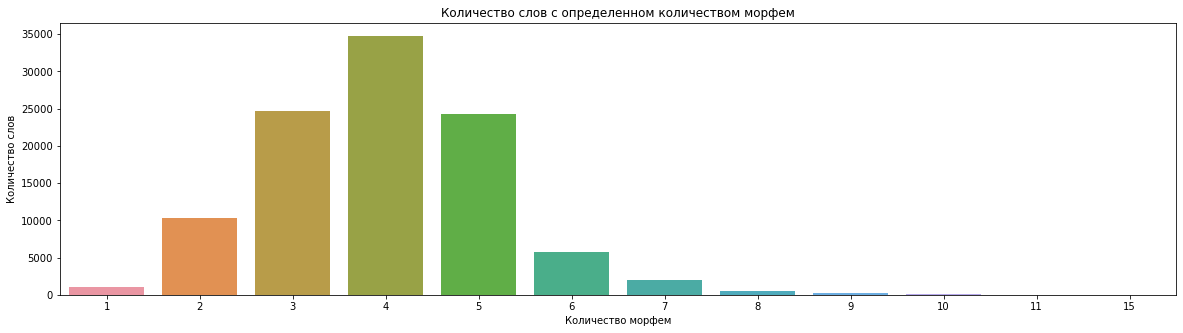

In [22]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.countplot(x=morph_df['count_morph'])

ax.set_title('Количество слов с определенном количеством морфем')
ax.set_ylabel('Количество слов')
ax.set_xlabel('Количество морфем')

plt.show()

Заметим, что мы можем выделить примерно нормальное распределение со средним в значении 4, а морфем больше 7 очень мало.

Нормализуем длину от 0 до 1 по методу минимакс так, чтобы значение 0.5 соотносилось со средним значением. Для этого за минимум возьмем значение 1, за максимум 7.

На вход будем принимать нормальную форму слова (будем приводить к лемме), так как слова берутся из словаря с леммами. Если слова нет в словаре, то не будем учитывать данный параметр.

In [23]:
MIN_MORPH = 1
MAX_MORPH = 7

def word_morph_param(lemma: str) -> Optional[float]:
    found_lemma = morph_df[morph_df['Lemma'] == lemma]
    if found_lemma.empty:
        return None
    count_morph = found_lemma['count_morph'].head(1).item()
    normalize_morph = (count_morph - MIN_MORPH) / (MAX_MORPH - MIN_MORPH)
    return max(0, min(normalize_morph, 1))

Протестируем

In [24]:
print(word_morph_param(lemma='None'))
print(word_morph_param(lemma='я'))
print(word_morph_param(lemma='стол'))
print(word_morph_param(lemma='припрыгивать'))
print(word_morph_param(lemma='пританцовывать'))
print(word_morph_param(lemma='авиационноспортивный'))

None
0
0.16666666666666666
0.5
0.6666666666666666
1.0


### Финальная функция определения сложности слова

Объединим все параметры сложности слова и возьмем среднее значение от их результата - это и будет общая сложность слова от 0 до 1.

In [25]:
def word_difficulty(word: str) -> dict:
    word, lemma, POS = transform_word(word)
    params = {'word_phoneme_param': word_phoneme_param(word),
              'word_length_param': word_length_param(word),
              'word_freq_param': word_freq_param(lemma),
              'word_POS_param': word_POS_param(POS),
              'word_morph_param': word_morph_param(lemma)}
    difficulty = np.mean([param for param in params.values() if param is not None])
    return {'difficulty': difficulty, 'params': params}

Возьмем небольшой текст, чтобы мы могли протестировать сложность слов. Например, цитату из 'Алисы в стране чудес' Льюиса Кэрролла.

In [26]:
text_df = pd.DataFrame(columns=list(['word', 'difficulty']))

with open('files/AliceInWonderland.txt', 'rb') as f:
    delete_symbols = set(string.punctuation)
    delete_symbols.remove('-')
    for word in f.read().decode('utf-8').split():
        word = ''.join([w for w in word.lower().replace(' ', '') if w not in delete_symbols])
        if word and text_df[text_df['word'] == word].empty:
            difficulty = word_difficulty(word)
            row = {'word': word,
                   'difficulty': difficulty['difficulty'], }
            row.update(difficulty['params'])
            text_df = text_df.append(row, ignore_index=True)
text_df.sort_values(by=['difficulty', 'word'])

,word,difficulty,word_POS_param,word_freq_param,word_length_param,word_morph_param,word_phoneme_param
21,а,0.000000,0.0,0.0,0.0,None,0.0
92,бы,0.000000,0,0,0.0,0,0.0
367,вам,0.000000,0,0,0.0,None,0.0
365,вы,0.000000,0,0,0.0,None,0.0
297,да,0.000000,0,0,0.0,None,0.0
...,...,...,...,...,...,...,...
745,изнеможение,0.735578,0.5,0.811224,0.7,0.666667,1.0
369,невежественная,0.774490,0.5,0.872449,1.0,0.5,1.0
739,вскарабкаться,0.786803,0.5,0.867347,0.9,0.666667,1.0
426,заплетающимся,0.857007,1,0.918367,0.9,0.666667,0.8


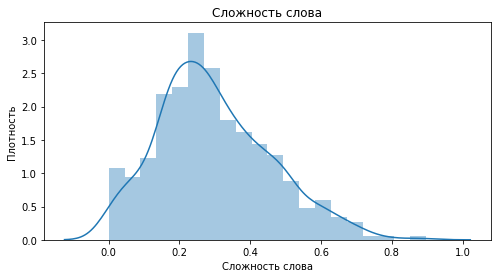

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(x=text_df['difficulty'])

ax.set_title('Сложность слова')
ax.set_ylabel('Плотность')
ax.set_xlabel('Сложность слова')

plt.show()

# Весь нужный код

In [28]:
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import os
import shutil
from typing import Optional
import warnings
import pymorphy2
warnings.filterwarnings('ignore')

# Константы
morph = pymorphy2.MorphAnalyzer()

MIN_PHONEME = 0
MAX_PHONEME = 5

MIN_LENGTH = 4
MAX_LENGTH = 14

MIN_FREQ = 0.4
MAX_FREQ = 20

simple_POS = {'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}
medium_POS = {'NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN'}
difficult_POS = {'PRTF', 'PRTS', 'GRND'}

MIN_MORPH = 1
MAX_MORPH = 7

# Датасеты
dirname = 'datasets/freq'
r = requests.get('http://dict.ruslang.ru/Freq2011.zip')
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall(dirname)
freq_df = pd.read_csv(os.path.join(dirname, 'freqrnc2011.csv'), sep='\t')[['Lemma', 'Freq(ipm)']]
freq_df['Lemma'] = freq_df['Lemma'].str.lower()
freq_df['length'] = freq_df['Lemma'].str.len()

dirname = 'datasets/tikhonov'
fullname = os.path.join(dirname, 'tikhonov.txt')
shutil.rmtree(dirname, ignore_errors=True)
r = requests.get('http://www.speakrus.ru/dict2/tikhonov.zip')
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall(dirname)
with open(os.path.join(dirname, os.listdir(dirname)[0]), 'rb') as f:
    text = f.read().decode('cp1251')
    with open(fullname, 'wb') as ru:
        ru.write(text.encode('utf-8'))    
morph_df = pd.read_csv(fullname, sep='|', names=['Lemma', 'analysis'])
morph_df['Lemma'] = morph_df['Lemma'].str.replace('\d+', '').str.split().str[0].str.lower()
morph_df['analysis'] = morph_df['analysis'].str.replace('\d+', '').str.split(pat=',', n=1).str[0].str.split().str[0]
morph_df['count_morph'] = morph_df['analysis'].str.count(pat='/') + 1

# Вспомогательные функции
def transform_word(word: str) -> tuple:
    word = word.lower().strip()
    morph_parse = morph.parse(word)[0]
    return word, morph_parse.normal_form, morph_parse.tag.POS 

vowels = set('аяоёуюыиэе')
consonants = set('бвгджзйклмнпрстфхцчшщ')
marks = set('ъь')

deaf_consonants = set('пфктшсхцчщ')
voices_consonants = set('лмнрйбвгджз')

ioted_vowels = { 
    'я' : {'one': 'а', 'two': 'йа'},
    'ё' : {'one': 'о', 'two': 'йо'},
    'ю' : {'one': 'у', 'two': 'йу'},
    'е' : {'one': 'э', 'two': 'йэ'},
}

stress_vowels = {
    'о': {'stress': 'о', 'not_stress': 'a'},
    'е': {'stress': 'э', 'not_stress': 'и'},
    'я': {'stress': 'а', 'not_stress': 'и'},
}

deaf_pairs = {
    'б': 'п',
    'в': 'ф',
    'г': 'к',
    'д': 'т',
    'ж': 'ш',
    'з': 'с'
}

simple_groups = { #abc -> ac
    'с' : {'т': set('нл')}, # стн, стл 
    'н' : {'д': set('шц'), 'т': 'г'}, # ндш, ндц, нтг
    'з' : {'д': set('нц')}, # здн, здц
    'р' : {'д': set('цч')} # рдц, рдч 
}

sh_groups = { # ab -> шb
    'ч' : set('нт') # чн, чт
}

sch_groups = { # ab -> щ
    'с' : 'ч', # сч
    'з' : 'ч', # зч
    'ж' : 'ч', # жч
}

def get_transcription(word: str) -> tuple:
    difficulty = [0] * len(word)
    transcription = ['!'] * len(word)
    for i in range(len(word)):
        c = word[i]
        before_c = word[i - 1] if i > 0 else None
        after_c = word[i + 1] if i < len(word) - 1 else None
        after_after_c = word[i + 2] if i < len(word) - 2 else None
        if c in vowels:
            transcription[i] = c
            difficulty[i] = 0
            if c in ioted_vowels:
                if i == 0 or before_c in vowels or before_c in marks:
                    transcription[i] = ioted_vowels[c]['two']
                    difficulty[i] = 2
                else:
                    transcription[i] = ioted_vowels[c]['one']
                    difficulty[i] = 1
            elif c == 'и':
                if before_c == 'ь':
                    transcription[i] = 'йи'
                    difficulty[i] = 2
                elif before_c in set('жшц'):
                    transcription[i] = 'ы'
                    difficulty[i] = 1
                else:
                    transcription[i] = 'и'
                    difficulty[i] = 0
            elif c in stress_vowels:
                transcription[i] = stress_vowels[c]['not_stress']
                difficulty[i] = 1
        elif c in consonants:
            transcription[i] = c
            difficulty[i] = 0
            if c in deaf_pairs:
                if i == len(word) - 1 or after_c in deaf_consonants:
                    transcription[i] = deaf_pairs[c]
                    difficulty[i] = 1
            if before_c and after_c and\
                before_c in simple_groups and\
                c in simple_groups[before_c] and\
                after_c in simple_groups[before_c][c]:
                transcription[i] = ''
                difficulty[i] = 1
            if before_c in sh_groups and c in sh_groups[before_c]:
                transcription[i - 1] = 'ш'
                difficulty[i - 1] = 1
            if before_c in sch_groups and c in sch_groups[before_c]:
                transcription[i - 1] = 'щ'
                difficulty[i - 1] = 1
                transcription[i] = ''
                difficulty[i] = 1
            if before_c == 'л' and c == 'н' and after_c == 'ц':
                transcription[i - 1] = ''
                difficulty[i - 1] = 1
            if before_c == 'в' and c == 'с' and after_c == 'т' and after_after_c == 'в':
                transcription[i - 1] = ''
                difficulty[i - 1] = 1
            if i == 0 and c == 'с' and after_c in voices_consonants:
                transcription[i] = 'з'
                difficulty[i] = 1
            if c == 'г' and after_c in deaf_consonants:
                transcription[i] = 'x'
                difficulty[i] = 1
            if before_c == c:
                transcription[i] = ''
                difficulty[i] = 1
        else:
            transcription[i] = ''
            difficulty[i] = 1
    if word.endswith(('ого', 'его')):
        transcription[-2] = 'в'
        difficulty[-2] = 1
    if word.endswith('тся'):
        transcription[-3] = 'ц'
        difficulty[-3] = 1
        transcription[-2] = ''
        difficulty[-2] = 1
    if word.endswith('ться'):
        transcription[-4] = 'ц'
        difficulty[-4] = 1
        transcription[-3] = ''
        difficulty[-3] = 1
        transcription[-2] = ''
        difficulty[-2] = 1
    return sum(difficulty), difficulty, transcription

def word_phoneme_param(word: str) -> float:
    difficulty, _, _= get_transcription(word)
    normalize_phoneme = (difficulty - MIN_PHONEME) / (MAX_PHONEME - MIN_PHONEME)
    return max(0, min(normalize_phoneme, 1))

def word_length_param(word: str) -> float:
    normalize_length = (len(word) - MIN_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
    return max(0, min(normalize_length, 1))

def word_freq_param(lemma: str) -> Optional[float]:
    found_lemma = freq_df[freq_df['Lemma'] == lemma]
    if found_lemma.empty:
        return None
    freq = found_lemma['Freq(ipm)'].head(1).item()
    normalize_freq = (freq - MIN_FREQ) / (MAX_FREQ - MIN_FREQ)
    return 1 - max(0, min(normalize_freq, 1))

def word_POS_param(POS: str) -> Optional[float]:
    if POS in simple_POS:
        return 0
    if POS in medium_POS:
        return 0.5
    if POS in difficult_POS:
        return 1
    return None

def word_morph_param(lemma: str) -> Optional[float]:
    found_lemma = morph_df[morph_df['Lemma'] == lemma]
    if found_lemma.empty:
        return None
    count_morph = found_lemma['count_morph'].head(1).item()
    normalize_morph = (count_morph - MIN_MORPH) / (MAX_MORPH - MIN_MORPH)
    return max(0, min(normalize_morph, 1))

# Главная функция
def word_difficulty(word: str) -> dict:
    word, lemma, POS = transform_word(word)
    params = {'word_phoneme_param': word_phoneme_param(word),
              'word_length_param': word_length_param(word),
              'word_freq_param': word_freq_param(lemma),
              'word_POS_param': word_POS_param(POS),
              'word_morph_param': word_morph_param(lemma)}
    difficulty = np.mean([param for param in params.values() if param is not None])
    return {'difficulty': difficulty, 'params': params}